# TensorFlow examples

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version: {0}".format(tf.__version__))

TensorFlow version: 1.15.0


## Simple calculation
$ z = w \times x + b $ 

In [2]:
# create a graph
g1 = tf.Graph()
with g1.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    
    z = w * x + b
    
    init = tf.global_variables_initializer()

# create a session and pass in a graph g
with tf.Session(graph=g1) as sess:
    # initialize w and b:
    sess.run(init)
    # evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print('x={0:.1f} --> z={1:.1f}'.format(t, sess.run(z, feed_dict={x:t})))

x=1.0 --> z=2.7
x=0.6 --> z=1.9
x=-1.8 --> z=-2.9


## Reshape rank-3 tensor, compute column sums and means

In [5]:
g2 = tf.Graph()
with g2.as_default():
    # input tensor
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, 2, 3),
                       name='input_x')
    # reshape input
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')
    # calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    # calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.Session(graph=g2) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print("Input tensor:\n{0}\nInput shape:\n{1}".format(x_array, x_array.shape))
    x_resh = sess.run(x2, feed_dict={x:x_array})
    print("Reshaped:\n{0}\nReshaped shape\n{1}:".format(x_resh, x_resh.shape))
    print("Column sums:\n{0}".format(sess.run(xsum, feed_dict={x:x_array})))
    print("Column means:\n{0}".format(sess.run(xmean, feed_dict={x:x_array})))

Input tensor:
[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
Input shape:
(3, 2, 3)
Reshaped:
[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Reshaped shape
(3, 6):
Column sums:
[18. 21. 24. 27. 30. 33.]
Column means:
[ 6.  7.  8.  9. 10. 11.]


## Ordinary Least Squares (OLS) regression
Implementing a simple Ordinary Least Squares (OLD) OLS regression model:

$ z = w \times x + b $

using the Mean of Squared Error (MSE) cost function:

$ MSE = \frac{1} {n} \sum \limits_{i=1}^n \left( y_i - \hat{y}_i \right) ^2 $

### Define the model

In [8]:
class TfLinreg(object):
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        # build the model
        with self.g.as_default():
            # set graph-level random seed
            tf.set_random_seed(random_seed)
            
            self.build()
            # create initializer
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        # define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        # define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w * self.X + b, name='z_net')
        print(self.z_net)
        # compute squared errors
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        # compute mean cost
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=self.learning_rate,
            name = 'GradientDescent'
        )
        
        self.optimizer = optimizer.minimize(self.mean_cost)
        

### Train the model

In [9]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                   2.0, 5.0, 6.3,
                   6.6, 7.4, 8.0, 9.0])
       
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Net input: Tensor("z_net:0", dtype=float32)
Squared errors: Tensor("sqr_errors:0", dtype=float32)


In [10]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    # initialize all variables: W and b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                           feed_dict={model.X: X_train,
                                      model.y: y_train})
        training_costs.append(cost)
    
    return training_costs

In [11]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)
print("Model fit")

Model fit


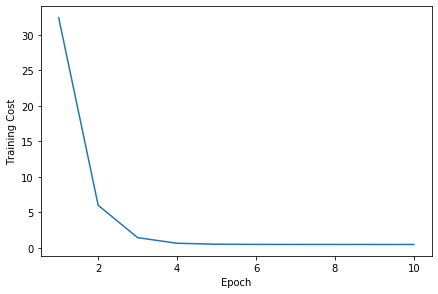

In [13]:
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

### Use the model to make predictions

In [14]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X: X_test})
    return y_pred

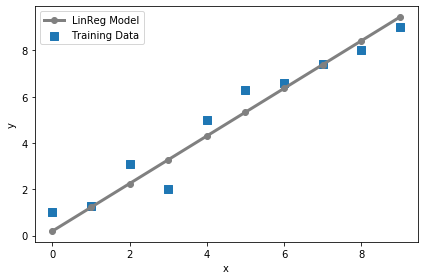

In [15]:
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]),
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()
